# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report
import random

# Create Data

In [2]:
np.random.seed(11)  

# Number of samples
n_samples = 500

# Generate synthetic data for weights (in kg)
weights = np.random.uniform(50, 120, n_samples)

# Generate synthetic data for heights (in cm) and convert to meters
heights = np.random.normal(170, 10, n_samples) / 100  # Convert to meters

# Calculate BMI
bmi = weights / (heights ** 2)

# Obese if BMI >= 30
obese = (bmi >= 30).astype(int)

# Add noise (if needed)
noise_factor = 0.05
n_noisy = int(noise_factor * n_samples)

# Randomly choose indices to flip
noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)

# Flip labels at noisy indices
obese[noisy_indices] = 1 - obese[noisy_indices]

# Create a DataFrame
data = pd.DataFrame({
    'weight': weights,
    'height': heights,
    'obese': obese
})

# Display the first few rows of the DataFrame
data.head()

,weight,height,obese
0,62.618878,1.729467,0
1,51.363267,1.595362,0
2,82.425297,1.765446,0
3,100.745375,1.705937,1
4,79.414252,1.754890,0


# Plot

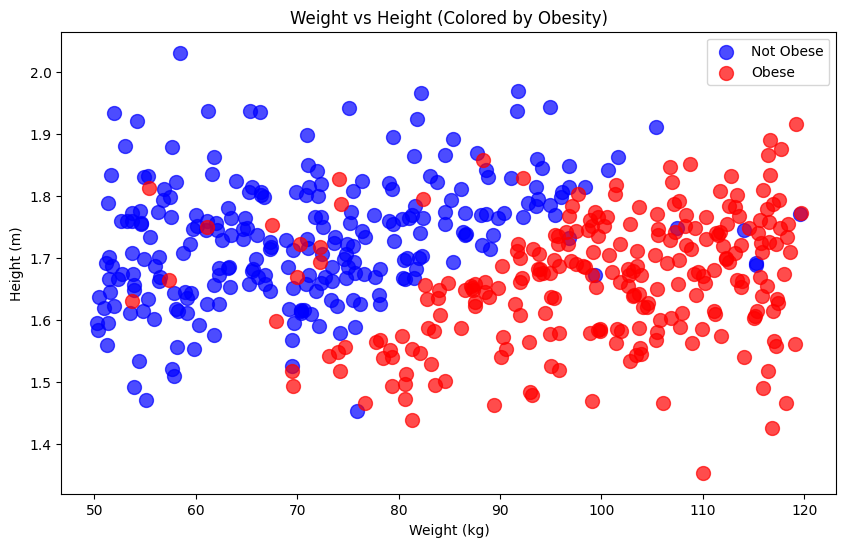

In [3]:
# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot non-obese individuals
plt.scatter(data[data['obese'] == 0]['weight'], data[data['obese'] == 0]['height'], 
            color='blue', label='Not Obese', alpha=0.7, s=100)

# Plot obese individuals
plt.scatter(data[data['obese'] == 1]['weight'], data[data['obese'] == 1]['height'], 
            color='red', label='Obese', alpha=0.7, s=100)

# Add labels and title
plt.title('Weight vs Height (Colored by Obesity)')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (m)')
plt.legend()

# Show plot
plt.show()

In [4]:
X = data[['weight','height']].values
y = data['obese'].values

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Sigmoid Function

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# BCE

In [6]:
def error_function(y_true, y_predicted):
    # Ensure predictions are clipped to avoid log(0) errors
    y_predicted = np.clip(y_predicted, 1e-15, 1 - 1e-15)
    
    # Calculating Binary Cross-Entropy loss
    cost = -np.sum(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted)) / len(y_true)
    
    return cost

### Binary Cross Entropy (BCE)

#### 1. BCE Loss Function

The binary cross entropy (BCE) loss function is given by:

$$
\text{BCE} = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right)
$$

where:

- \( y_i \) is the true label (0 or 1).
- \( \hat{y}_i \) is the predicted probability, calculated using the logistic (sigmoid) function:

$$
\hat{y}_i = \sigma(wx_i + b) = \frac{1}{1 + e^{-(wx_i + b)}}
$$

#### 2. Derivative with respect to weight \( w \)

The derivative of the BCE loss with respect to the weight \( w \) is:

$$
\frac{\partial \text{BCE}}{\partial w} = -\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) \cdot x_i
$$

#### 3. Derivative with respect to bias \( b \)

The derivative of the BCE loss with respect to the bias \( b \) is:

$$
\frac{\partial \text{BCE}}{\partial b} = -\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)
$$


# Gradient Descent

In [7]:
def batch_gradient_descent(x, y, batch_size, epochs, learning_rate, stopping_threshold=1e-6):
    # Initialize weights and bias
    current_weights = np.random.uniform(-0.5, 0.5, size=x.shape[1])  
    current_bias = -3
    n = len(x)
    
    costs = []
    weights = []
    biases = []
    previous_cost = None
    
    for iterations in range(epochs):
        # Shuffle data for each iteration
        indices = np.arange(n)
        np.random.shuffle(indices)
        
        x_shuffled = x[indices]
        y_shuffled = y[indices]
        
        for i in range(0, n, batch_size):
            x_batch = x_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            
            # Making predictions
            y_predicted = sigmoid(np.dot(x_batch, current_weights) + current_bias)
            current_cost = error_function(y_batch, y_predicted)
 
            if previous_cost and abs(previous_cost - current_cost) <= stopping_threshold:
                return weights, biases, costs
            
            previous_cost = current_cost
            costs.append(current_cost)
            weights.append(current_weights.copy())
            biases.append(current_bias)
            
            # Calculating gradients
            error = y_predicted - y_batch
            weight_derivative = (1 / len(x_batch)) * np.dot(x_batch.T, error)
            bias_derivative = np.mean(error)
            
            # Updating weights and bias
            current_weights -= learning_rate * weight_derivative
            current_bias -= learning_rate * bias_derivative
                 
    return np.array(weights), np.array(biases), costs

# Plot Cost Function

In [8]:
epochs = 100
learning_rate = 0.001
batch_size = len(x_train) # 1 for SGD|

In [9]:
%matplotlib tk

In [10]:

weights, biases, costs = batch_gradient_descent(x_train, y_train, batch_size, epochs, learning_rate)

# Create plot for animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

def plot_decision_boundary(ax, weights, bias, x, y, iteration):
    ax.clear()
    h = .02
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], weights) + bias)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    ax.set_title(f'Iteration: {iteration + 1}\nCost: {costs[iteration]:.4f}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return scatter

def plot_cost_curve(ax, costs, iteration):
    ax.clear()
    ax.plot(range(len(costs)), costs, 'b-', label='Cost')
    ax.scatter(iteration, costs[iteration], color='r', s=50, zorder=5, label='Current Cost')
    ax.set_title('Cost Curve')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.legend(loc='upper right')
    return ax

def animate(iteration):
    if iteration == 0:
        # Plot initialization
        ax1.clear()
        ax1.set_title(f'Initial Weights: {weights[0]}\nInitial Bias: {biases[0]}')
        ax1.set_xlabel('Feature 1')
        ax1.set_ylabel('Feature 2')
        
        ax2.clear()
        ax2.plot(range(len(costs)), costs, 'b-', label='Cost')
        ax2.set_title('Cost Curve')
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Cost')
        ax2.scatter(0, costs[0], color='r', s=50, zorder=5, label='Current Cost')
        ax2.legend(loc='upper right')
    else:
        plot_decision_boundary(ax1, weights[iteration], biases[iteration], x_train, y_train, iteration)
        plot_cost_curve(ax2, costs, iteration)
    return ax1, ax2

# Create animation
anim = FuncAnimation(fig, animate, frames=len(weights) + 1, repeat=False, interval=200)

plt.show()

# Get Model

In [11]:
best_index = np.argmin(costs)
print("The best weight Iteration", best_index)

best_model = {}

best_model['coef_'] = weights[best_index]
best_model['intercept_'] =biases[best_index]

print(best_model)

print(f"Best Weight: {best_model['coef_']} Best Bias: {best_model['intercept_']}")

The best weight Iteration 99
{'coef_': array([ 0.04690764, -0.47485132]), 'intercept_': -3.0053536144442425}
Best Weight: [ 0.04690764 -0.47485132] Best Bias: -3.0053536144442425


In [12]:
latest_model = {}

latest_model['coef_'] = weights[-1]
latest_model['intercept_'] =biases[-1]

print(latest_model)

print(f"Best Weight: {latest_model['coef_']} Best Bias: {latest_model['intercept_']}")

{'coef_': array([ 0.04690764, -0.47485132]), 'intercept_': -3.0053536144442425}
Best Weight: [ 0.04690764 -0.47485132] Best Bias: -3.0053536144442425


# Evaluate

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [14]:
def predict(x, weights, bias):
    z = np.dot(x, weights) + bias
    return sigmoid(z) >= 0.5

# Best Model

In [15]:
# Predict using final model
y_pred = predict(x_test, best_model['coef_'], best_model['intercept_'])

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8667
Precision: 0.8000
Recall: 0.9577
F1 Score: 0.8718
Confusion Matrix:
[[62 17]
 [ 3 68]]


In [16]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        79
           1       0.80      0.96      0.87        71

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



In [17]:
%matplotlib inline

The best weight Iteration 99
{'coef_': array([ 0.04690764, -0.47485132]), 'intercept_': -3.0053536144442425}
Best Weight: [ 0.04690764 -0.47485132] Best Bias: -3.0053536144442425


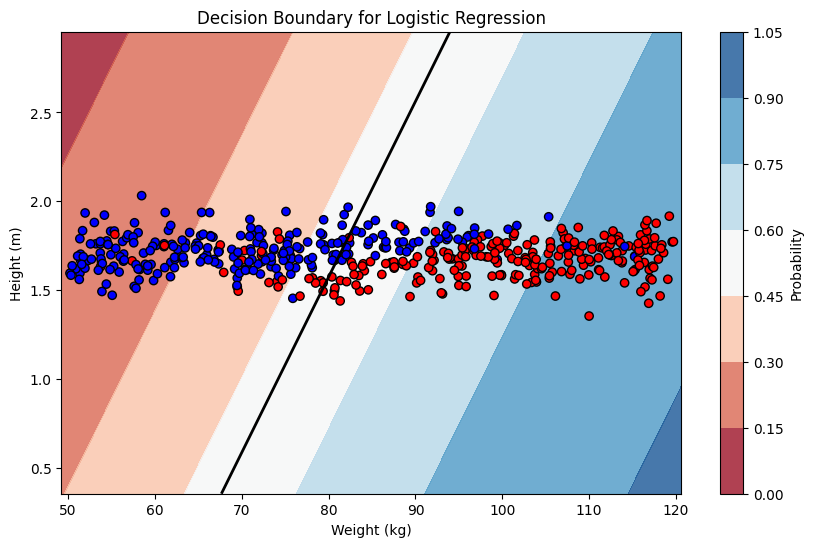

In [18]:
def predict_logistic_regression(X, weights, bias):
    linear_combination = np.dot(X, weights) + bias
    predictions = 1 / (1 + np.exp(-linear_combination))
    return predictions

# Function to plot decision boundary with colored regions using best_model
def plot_decision_boundary_with_best_model(X, y, best_model, title='Decision Boundary for Logistic Regression'):
    # Extract coefficients and bias from the best model
    weights = best_model['coef_']
    bias = best_model['intercept_']

    # Determine the min and max values for both axes
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a meshgrid for plotting
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Prepare the meshgrid points for prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict probabilities over the grid using the logistic regression equation
    Z = predict_logistic_regression(mesh_points, weights, bias)
    Z = Z.reshape(xx.shape)

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot the probability regions
    contour = plt.contourf(xx, yy, Z, cmap='RdBu', alpha=0.8)

    # Add a color bar to indicate probability values
    cbar = plt.colorbar(contour)
    cbar.set_label('Probability')

    # Plot the decision boundary (where probability is 0.5)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'red']))

    # Set labels and title
    plt.xlabel('Weight (kg)')
    plt.ylabel('Height (m)')
    plt.title(title)

    # Display the plot
    plt.show()


# Find the best weight iteration based on the minimum cost
best_index = np.argmin(costs)
print("The best weight Iteration", best_index)

# Extract the best model parameters
best_model = {
    'coef_': weights[best_index],
    'intercept_': biases[best_index]
}

print(best_model)
print(f"Best Weight: {best_model['coef_']} Best Bias: {best_model['intercept_']}")

# Plot the decision boundary using the best model
plot_decision_boundary_with_best_model(X, y, best_model)

# Latest Model

In [19]:

# Predict using final model
y_pred = predict(x_test, latest_model['coef_'], latest_model['intercept_'])

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8667
Precision: 0.8000
Recall: 0.9577
F1 Score: 0.8718
Confusion Matrix:
[[62 17]
 [ 3 68]]


In [20]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        79
           1       0.80      0.96      0.87        71

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



{'coef_': array([ 0.04690764, -0.47485132]), 'intercept_': -3.0053536144442425}
Best Weight: [ 0.04690764 -0.47485132] Best Bias: -3.0053536144442425


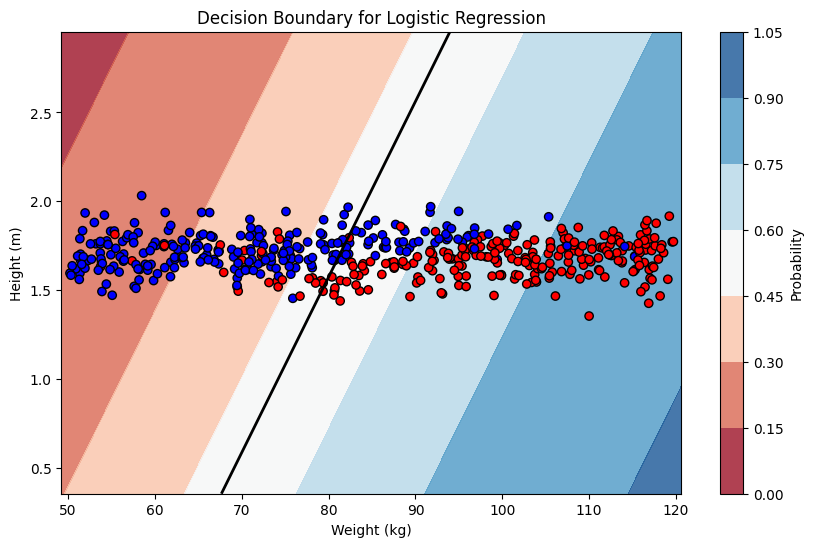

In [21]:
def predict_logistic_regression(X, weights, bias):
    linear_combination = np.dot(X, weights) + bias
    predictions = 1 / (1 + np.exp(-linear_combination))
    return predictions

# Function to plot decision boundary with colored regions using best_model
def plot_decision_boundary_with_best_model(X, y, best_model, title='Decision Boundary for Logistic Regression'):
    # Extract coefficients and bias from the best model
    weights = best_model['coef_']
    bias = best_model['intercept_']

    # Determine the min and max values for both axes
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a meshgrid for plotting
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Prepare the meshgrid points for prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict probabilities over the grid using the logistic regression equation
    Z = predict_logistic_regression(mesh_points, weights, bias)
    Z = Z.reshape(xx.shape)

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot the probability regions
    contour = plt.contourf(xx, yy, Z, cmap='RdBu', alpha=0.8)

    # Add a color bar to indicate probability values
    cbar = plt.colorbar(contour)
    cbar.set_label('Probability')

    # Plot the decision boundary (where probability is 0.5)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['blue', 'red']))

    # Set labels and title
    plt.xlabel('Weight (kg)')
    plt.ylabel('Height (m)')
    plt.title(title)

    # Display the plot
    plt.show()


# Extract the best model parameters
best_model = {
    'coef_': weights[-1],
    'intercept_': biases[-1]
}

print(best_model)
print(f"Best Weight: {best_model['coef_']} Best Bias: {best_model['intercept_']}")

# Plot the decision boundary using the best model
plot_decision_boundary_with_best_model(X, y, best_model)